In [1]:
from __future__ import print_function, division
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import nipy.algorithms.statistics.empirical_pvalue as pv

import congress_tools as cong

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [ ]:
year = 2014

# reapportion seats to expected values
methodReapportion = 'state'

# this file was saved by nExpectedReps_compactSummary.ipynb
filename = '../data/df_stateSummary_%d_%sReapportion.pkl' % (year, methodReapportion)
data = pd.read_pickle(filename)

# Summary: State-level reapportionment

In [187]:
print('Expected seats %d:\nDemocratic: %d\nRepublican: %d' % (year,data.nDemDistExpect.sum(), data.nRepDistExpect.sum()))

Expected seats 2014:
Democratic: 201
Republican: 234


# Analysis: Compactness and Redistricting Control

## Get average compactness for states with different redistricting control

In [11]:
data['avg_compact'] = data.compact.apply(np.mean)
#using avg compactness
treatment_oneParty_avgCompact = data[data['redist_ctrl'].isin(['D','R'])]['avg_compact']
treatment_split_avgCompact = data[data['redist_ctrl'].isin(['Split','Nonpartisan'])]['avg_compact']

In [155]:
# data is not normally distributed, need to transform
print("Before transformation")
print(stats.normaltest(treatment_oneParty_avgCompact))
print(stats.normaltest(treatment_split_avgCompact))
print("After log transformation")
print(stats.normaltest(treatment_oneParty_avgCompact.apply(np.log)))
print(stats.normaltest(treatment_split_avgCompact.apply(np.log)))

Before transformation
(6.5698815209004442, 0.037442803122508549)
(13.337726037258497, 0.00126984171691505)
After log transformation
(0.45101913497692925, 0.79810942450865019)
(3.1012070938129308, 0.21211991086862494)


In [15]:
# t-test 
stats.ttest_ind(treatment_oneParty_avgCompact.apply(np.log), 
                treatment_split_avgCompact.apply(np.log), equal_var=False)

(-3.1420995538277077, 0.0031574071144885906)

## Average district compactness in states with single-party control of redistricting are significantly less compact than those from states with split or nonpartisan controlm

In [158]:
print('Compactness:')
print('Single-party redistricting control: %.4f' % treatment_oneParty_avgCompact.mean())
print('Split-party redistricting control: %.4f' % treatment_split_avgCompact.mean())

Compactness
Single-party redistricting control: 0.2210
Split-party redistricting control: 0.2838


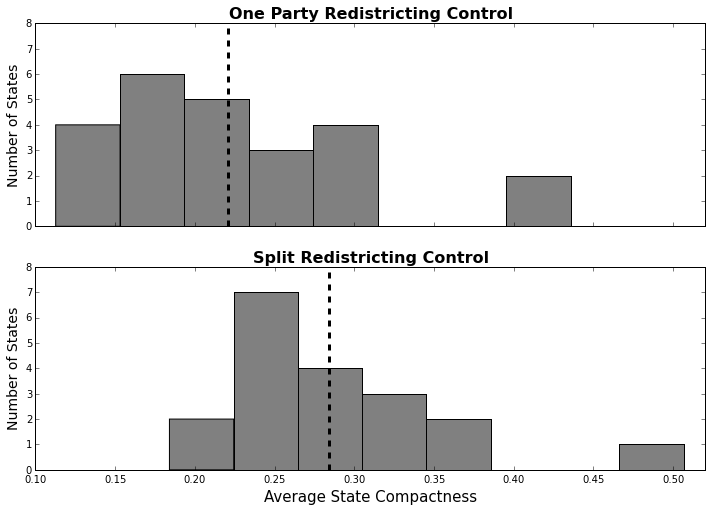

In [188]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12,8))

ax1.hist(list(treatment_oneParty_avgCompact), bins=8, color='grey')
ax2.hist(list(treatment_split_avgCompact), bins=8, color = 'grey')

ax2.set_ylim(0, 8)
ax2.set_xlim(0.1, 0.52)

ax1.set_ylabel("Number of States", fontsize=14)
ax2.set_ylabel("Number of States", fontsize=14)

ax2.set_xlabel("Average State Compactness", fontsize=16)

ax1.set_title('One Party Redistricting Control', fontweight='bold', fontsize=16)
ax2.set_title('Split Redistricting Control', fontweight='bold', fontsize=16)

# vertical lines at mean
ax1.axvline(treatment_oneParty_avgCompact.mean(), color='black', linestyle='dashed', linewidth=3)
ax2.axvline(treatment_split_avgCompact.mean(), color='black', linestyle='dashed', linewidth=3)

ax1.grid(False)
ax2.grid(False)

# plt.savefig("compact_redistControl.png", bbox_inches='tight', dpi = 1200)

# Analysis: Compactness and Gerrymandering Score

In [195]:
methodReapportion = 'state'

year = 2012
# year = 2014

# load district data
filename = '../data/df_distSummary_%d_%sReapportion.pkl' % (year, methodReapportion)
dfdist = pd.read_pickle(filename)

## Calculate a gerrymandering score using the number of packed and cracked districts and other criteria

In [196]:
# minimum number of districts a state needs to be included
minDist = 4

# the limits on vote proportion that one party needs in a given district to be packed
packMin = 75
packMax = 99

# the limits on vote proportion that one party needs to be cracked
crackMin = 35
crackMax = 49

scoreLim = 2
delta_R_lim = 1

printDebug = False

dfdist, state_gerry = cong.gerry_score(dfdist,minDist=minDist,
                                       packMin=packMin,packMax=packMax,
                                       crackMin=crackMin,crackMax=crackMax,
                                       scoreLim=scoreLim,delta_R_lim=delta_R_lim,printDebug=printDebug)

seat difference: 26 (positive indicates number of R seats that should be D)
[u'MI', u'AL', u'TX', u'SC', u'PA', u'OH', u'VA', u'NC', u'IN', u'FL']


In [197]:
# Separate districts from gerrymandered and non-gerrymandered states
dfdist_gm = dfdist[dfdist['state'].isin(state_gerry)]
dfdist_nogm = dfdist[~dfdist['state'].isin(state_gerry)]

In [198]:
# data is not normally distributed, need to transform
print("Before transformation")
print(stats.normaltest(dfdist_gm['compact']))
print(stats.normaltest(dfdist_nogm['compact']))
print("After sqrt transformation")
print(stats.normaltest(dfdist_gm['compact']**.5))
print(stats.normaltest(dfdist_nogm['compact']**.5))

Before transformation
(15.549719198286761, 0.00042016645694516153)
(20.627299788595963, 3.3177126036509291e-05)
After sqrt transformation
(4.6019953640994702, 0.10015886715480074)
(0.3160547909537525, 0.85382639066693344)


In [199]:
# t-test
stats.ttest_ind(dfdist_gm['compact']**.5, 
                dfdist_nogm['compact']**.5, equal_var=False)

(-3.1673863017585977, 0.0017017155350526607)

## Districts from gerrymandered states are significantly less compact than those from non-gerrymandered states

In [306]:
print('Compactness by Gerrymandering')
print('Gerrymandered: %.4f' % dfdist_gm['compact'].mean())
print('Non-gerrymandered: %.4f' % dfdist_nogm['compact'].mean())

Compactness by Gerrymandering
Gerrymandered: 0.2205
Non-gerrymandered: 0.2537


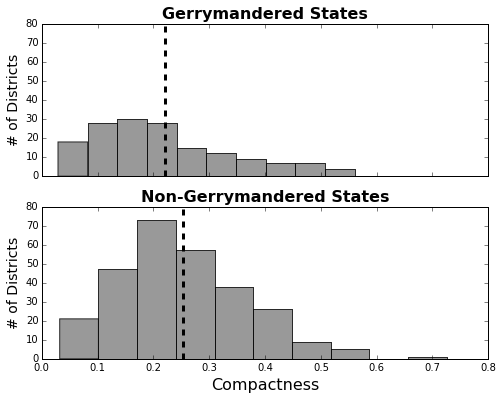

In [203]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')

ymax = 80
xmin = 0
xmax = 0.8

dfdist_gm['compact'].hist(ax=ax1, alpha=0.8, color='gray', bins=15)
dfdist_nogm['compact'].hist(ax=ax2, alpha=0.8, color='gray', bins=15)
# vertical mean lines
ax1.axvline(dfdist_gm['compact'].mean(), color='black', linestyle='dashed', linewidth=3)
ax2.axvline(dfdist_nogm['compact'].mean(), color='black', linestyle='dashed', linewidth=3)

# clean up plot
ax1.set_ylim(top=ymax)
ax2.set_ylim(top=ymax)
ax1.set_xlim(left=xmin, right=xmax)

ax1.set_ylabel('# of Districts', fontsize=14)
ax2.set_ylabel('# of Districts', fontsize=14)

ax2.set_xlabel('Compactness', fontsize=16, fontweight='normal')

ax1.grid(False)
ax2.grid(False)

weight = 'bold'
ax1.set_title('Gerrymandered States', fontweight=weight, fontsize=16)
ax2.set_title('Non-Gerrymandered States', fontweight=weight, fontsize=16)

# plt.savefig("gm_compact_%d.png" % (year),bbox_inches='tight', dpi = 1200)

# Analysis: Compactness and District PVI

In [210]:
methodReapportion = 'state'
# methodReapportion = 'country'

year = 2012
# year = 2014

# load district data
filename = '../data/df_distSummary_%d_%sReapportion.pkl' % (year, methodReapportion)
dfdist = pd.read_pickle(filename)

In [293]:
# convert PVI to integer
dfdist['pvi_dist'] = dfdist['pvi_dist'].astype(np.int)

In [296]:
# the states below have only one congressional district
oneCD = ['AK', 'DE', 'MT', 'ND', 'SD', 'VT', 'WY']
# create data frame without these states
df3states = dfdist[~dfdist.state.isin(oneCD)]

In [297]:
demS = df3states[df3states['pvi_dist'] > 5]
repS = df3states[(df3states['pvi_dist'] < -5)]
swS = df3states[(df3states['pvi_dist'] <=5) & (df3states['pvi_dist'] >= - 5)]

In [307]:
# data is not normally distributed, need to transform
print("Before transformation")
print(stats.normaltest(demS['compact']))
print(stats.normaltest(repS['compact']))
print(stats.normaltest(swS['compact']))
print("After sqrt transformation")
print(stats.normaltest(demS['compact']**0.5))
print(stats.normaltest(repS['compact']**0.5))
print(stats.normaltest(swS['compact']**0.5))

Before transformation
(15.768551362299874, 0.00037661930523347274)
(14.889970113859503, 0.00058436483254290135)
(10.638993446575057, 0.0048952167539897638)
After sqrt transformation
(1.103187636764509, 0.57603098957830978)
(5.4867572793241468, 0.064352555085359517)
(4.4849158592101359, 0.10619715818647513)


In [302]:
f_val, p_val = stats.f_oneway(demS['compact']**0.5, swS['compact']**0.5, repS['compact']**0.5) 
print([f_val, p_val])

[9.142062238425174, 0.00012962381814904329]


In [303]:
print(stats.ttest_ind(repS['compact']**0.5,swS['compact']**0.5, equal_var=False))
print(stats.ttest_ind(demS['compact']**0.5,swS['compact']**0.5,equal_var=False))
print(stats.ttest_ind(demS['compact']**0.5,repS['compact']**0.5,equal_var=False))

(-2.3430012418310611, 0.020152981677101986)
(-4.0422038547529793, 7.2152486190037811e-05)
(-2.3424164958765012, 0.019862974682074899)


In [ ]:
pv.fdr([0.020152981677101476,7.215*10**(-5), 0.019862974682074624])

### The average compactness of three groups is not the same. Democratic districts have lower compactness than Republican districts on average. Swing districts have the largest average compactness.

In [308]:
print('Compactness by PVI')
print('Democratic: %.4f' % demS['compact'].mean())
print('Republican: %.4f' % repS['compact'].mean())
print('Swing: %.4f' % swS['compact'].mean())

Compactness by PVI
Democratic: 0.2150
Republican: 0.2379
Swing: 0.2736


(0.0, 35)

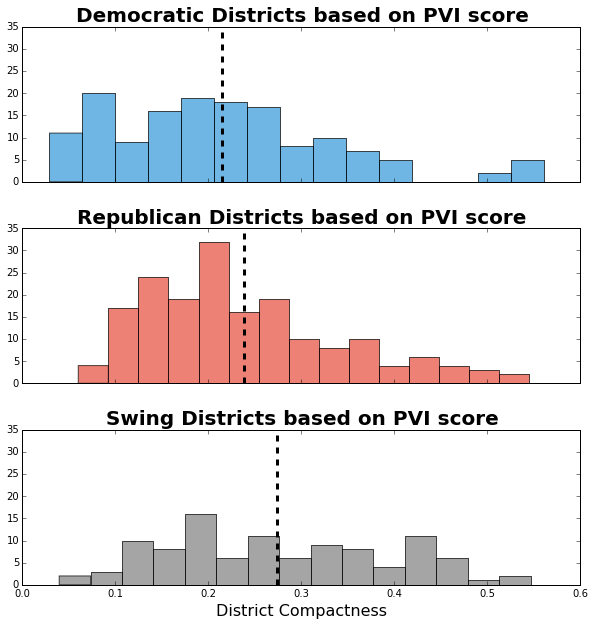

In [304]:
f, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True, sharey=True)
f.subplots_adjust(wspace=0.08,hspace=0.3)
f.set_size_inches(10,10)
# plot histograms
demS['compact'].hist(ax=ax1,color='#3498db', alpha = 0.7, bins=15)
repS['compact'].hist(ax=ax2,color='#e74c3c', alpha = 0.7, bins=15)
swS['compact'].hist(ax=ax3,color='grey', alpha = 0.7, bins=15)

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

# set labels
ax1.set_title('Democratic Districts based on PVI score', fontsize=20,fontweight='bold')
ax2.set_title('Republican Districts based on PVI score', fontsize=20,fontweight='bold')
ax3.set_title('Swing Districts based on PVI score', fontsize=20, fontweight='bold')

ax3.set_xlabel('District Compactness', fontsize=16)

ax1.axvline(demS['compact'].mean(), color='black', linestyle='dashed', linewidth=3)
ax2.axvline(repS['compact'].mean(), color='black', linestyle='dashed', linewidth=3)
ax3.axvline(swS['compact'].mean(), color='black', linestyle='dashed', linewidth=3)

ylim=35
ax1.set_ylim(top=ylim)
ax2.set_ylim(top=ylim)
ax3.set_ylim(top=ylim)
# plt.savefig("pvi_comp_hist.png",bbox_inches='tight', dpi = 1200 )

# DIME and Gerrymandering Score

In [310]:
methodReapportion = 'state'

year = 2012

filename = '../data/df_distSummary_DIME_%d_%sReapportion.pkl' % (year, methodReapportion)
dfjoin = pd.read_pickle(filename)

In [311]:
# convert PVI to integer
# dfjoin['pvi_dist'] = dfjoin['pvi_dist'].astype(np.int)

cfscore = 'cfscores.dyn'

In [334]:
# for cfscore
cf_dfdist_gm = dfjoin[dfjoin['state'].isin(state_gerry)].dropna()
cf_dfdist_nogm = dfjoin[~dfjoin['state'].isin(state_gerry)].dropna()

In [333]:
# data is not normally distributed, need to transform
print("Before transformation")
print(stats.normaltest(cf_dfdist_gm[cfscore]))
print(stats.normaltest(cf_dfdist_nogm[cfscore]))
# print("After log transformation")
# print(stats.normaltest(cf_dfdist_gm[cfscore].apply(np.log)))
# print(stats.normaltest(cf_dfdist_nogm[cfscore].apply(np.log)))

Before transformation
(22.202391917959648, 1.5094260903882928e-05)
(0.60636035809920197, 0.73846602827566377)
After log transformation
(nan, nan)
(nan, nan)


In [324]:
# t-test
stats.ttest_ind(cf_dfdist_gm[cfscore].dropna(), 
                cf_dfdist_nogm[cfscore].dropna(), equal_var=False)

(6.8510051694407768, 2.9319657256186254e-11)

In [356]:
# separate parties
liberalIdx = (dfjoin[cfscore] < 0)
conservIdx = (dfjoin[cfscore] > 0)

# for cfscore
liberalGM = dfjoin[dfjoin['state'].isin(state_gerry) & liberalIdx]
liberalNoGM = dfjoin[~dfjoin['state'].isin(state_gerry) & liberalIdx]

conservGM = dfjoin[dfjoin['state'].isin(state_gerry) & conservIdx]
conservNoGM = dfjoin[~dfjoin['state'].isin(state_gerry) & conservIdx]

In [357]:
print("Before transformation")
print(stats.normaltest(liberalGM[cfscore].dropna()))
print(stats.normaltest(liberalNoGM[cfscore].dropna()))
print(stats.normaltest(conservGM[cfscore].dropna()))
print(stats.normaltest(conservNoGM[cfscore].dropna()))

print("After Box-Cox transformation")
print(stats.normaltest(stats.boxcox(liberalGM[cfscore].dropna().abs())[0]))
print(stats.normaltest(stats.boxcox(liberalNoGM[cfscore].dropna().abs())[0]))
print(stats.normaltest(stats.boxcox(conservGM[cfscore].dropna().abs())[0]))
print(stats.normaltest(stats.boxcox(conservNoGM[cfscore].dropna().abs())[0]))

Before transformation
(7.6984069784978013, 0.021296692729268429)
(4.6627495408828068, 0.09716207967441802)
(18.273953970088016, 0.00010761215143681059)
(6.3455715761256561, 0.041886747617445409)
After Box-Cox transformation
(0.010634772047826944, 0.99469672624860339)
(5.1930586117243358, 0.074531806944095003)
(0.57767784515101261, 0.74913286407706337)
(2.367429849738977, 0.30613933887579753)


In [389]:
# compare four sub-groups
f_val, p_val = stats.f_oneway(stats.boxcox(liberalGM[cfscore].dropna().abs())[0], stats.boxcox(liberalNoGM[cfscore].dropna().abs())[0], stats.boxcox(conservGM[cfscore].dropna().abs())[0], stats.boxcox(conservNoGM[cfscore].dropna().abs())[0])
print([f_val, p_val])

[19.244893723137437, 9.9907072492967353e-12]


In [392]:
# liberal GM vs noGM
# this is the stat we report
stats.ttest_ind(stats.boxcox(liberalGM[cfscore].dropna().abs())[0], stats.boxcox(liberalNoGM[cfscore].dropna().abs())[0], equal_var=False)

[34.249265759004913, 2.0087994682178358e-08]


(-5.3067209726520401, 1.6275804724405473e-06)

In [393]:
# conservative GM vs noGM
stats.ttest_ind(stats.boxcox(conservGM[cfscore].dropna().abs())[0], stats.boxcox(conservNoGM[cfscore].dropna().abs())[0], equal_var=False)

[0.0042834887096234817, 0.94787289535594232]


(-0.065834794984177436, 0.94756572803515138)

liberal GM
count    44.000000
mean     -0.691741
std       0.312418
min      -1.705644
25%      -0.866046
50%      -0.630394
75%      -0.479092
max      -0.188839
Name: cfscores.dyn, dtype: float64
conserv GM
count    113.000000
mean       0.907650
std        0.234440
min        0.040448
25%        0.798699
50%        0.943509
75%        1.056692
max        1.342716
Name: cfscores.dyn, dtype: float64
dem ~GM
count    154.000000
mean      -0.940219
std        0.343131
min       -1.637502
25%       -1.201054
50%       -0.948659
75%       -0.730570
max       -0.101135
Name: cfscores.dyn, dtype: float64
conserv ~GM
count    123.000000
mean       0.914930
std        0.251666
min        0.083674
25%        0.755085
50%        0.934663
75%        1.113645
max        1.421921
Name: cfscores.dyn, dtype: float64


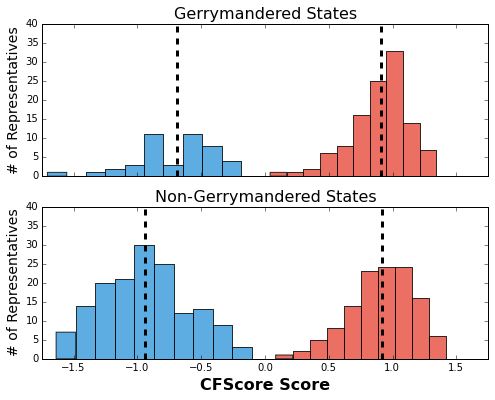

In [337]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')

ymax = 40
xmin = -1.75
xmax = 1.75

bins = 10

# plot separate party cfscore
liberalGM.hist(ax=ax1, alpha=0.8, color='#3498db', bins=bins)
conservGM.hist(ax=ax1, alpha=0.8, color='#e74c3c', bins=bins)

liberalNoGM.hist(ax=ax2, alpha=0.8, color='#3498db', bins=bins)
conservNoGM.hist(ax=ax2, alpha=0.8, color='#e74c3c', bins=bins)

ax1.axvline(liberalGM.mean(), color='black', linestyle='dashed', linewidth=3)
ax1.axvline(conservGM.mean(), color='black', linestyle='dashed', linewidth=3)

ax2.axvline(liberalNoGM.mean(), color='black', linestyle='dashed', linewidth=3)
ax2.axvline(conservNoGM.mean(), color='black', linestyle='dashed', linewidth=3)

# clean up plot
ax1.set_ylim(top=ymax)
ax2.set_ylim(top=ymax)

ax1.set_xlim(left=xmin, right=xmax)
# ax2.set_xlim(left=xmin, right=xmax)

ax1.set_ylabel('# of Representatives', fontsize=14)
ax2.set_ylabel('# of Representatives', fontsize=14)

ax2.set_xlabel('CFScore', fontsize=16, fontweight='bold')

ax1.grid(False)
ax2.grid(False)

weight = 'normal'
ax1.set_title('Gerrymandered States', fontweight=weight, fontsize=16)
ax2.set_title('Non-Gerrymandered States', fontweight=weight, fontsize=16)

# plt.savefig("gm_dime_%d.png" % (year),bbox_inches='tight', dpi = 1200)

print('liberal GM')
print(liberalGM.describe())
print('conserv GM')
print(conservGM.describe())
print('dem ~GM')
print(liberalNoGM.describe())
print('conserv ~GM')
print(conservNoGM.describe())